In [1]:
# todo: check the model cfg: augmentations, policy

In [1]:
from tqdm import tqdm
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm as colormap


import torch
from torch import nn
from utils import parse_cfg, predict_and_save
from darknet import Darknet

In [2]:
darknet = Darknet('cfg/yolov3_test_todel.cfg')
weight_file = 'weights/yolov3.weights'
darknet.load_weights(weight_file)
darknet.eval();

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms


In [3]:
device = torch.device('cpu:0')
model = darknet
labels_path='./data/coco.names'
img_path = 'dog-cycle-car.png'
# img_path = 'people_outside.jpg'
img_path = 'city_hall.jpg'
# img_path = '../../../../Screenshot 2019-03-16 at 21.51.49.png'
img_path = '../../../../lT5TP3HVQkE.jpg'
save_path = './output.jpg'
show = True

/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


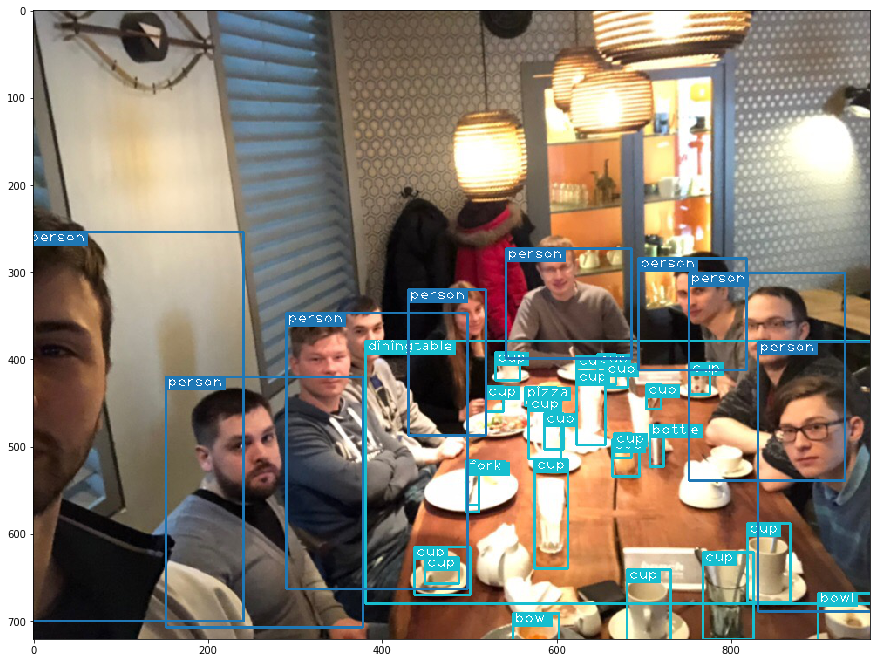

In [4]:
predict_and_save(img_path, save_path, model, device, labels_path, show)